## 1. Setup and Imports

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Standard libraries loaded")

✓ Standard libraries loaded


In [2]:
# Add parent directory to path for imports
import sys
sys.path.insert(0, '../')

# Import project modules
from src.data_loader import load_wine_quality, preprocess_data, split_data
from src.feature_analysis import FeatureAnalyzer, analyze_dataset
from src.baseline_models import BaselineComparison, train_and_evaluate_baseline

print("✓ Project modules loaded")

✓ Project modules loaded


In [3]:
# Create results directories
RESULTS_DIR = Path('../results/analysis')
FIGURES_DIR = RESULTS_DIR / 'figures'

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"✓ Results directory: {RESULTS_DIR}")
print(f"✓ Figures directory: {FIGURES_DIR}")

✓ Results directory: ../results/analysis
✓ Figures directory: ../results/analysis/figures


## 2. Load Wine Quality Dataset

In [4]:
# Load the dataset
DATA_DIR = '../data'

print("Loading Wine Quality dataset...")
X, y = load_wine_quality(DATA_DIR)

print(f"\nDataset loaded:")
print(f"  Samples: {X.shape[0]}")
print(f"  Features: {X.shape[1]}")
print(f"  Feature names: {list(X.columns)}")

Loading Wine Quality dataset...
Wine Quality Dataset loaded: 6497 samples, 12 features
Class distribution: {0: 5220, 1: 1277}

Dataset loaded:
  Samples: 6497
  Features: 12
  Feature names: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'wine_type']


In [5]:
# Preprocess data (binary classification)
X_processed, y_processed = preprocess_data(X, y)

print("Dataset preprocessed for binary classification (quality >= 7 vs < 7)")
print(f"\nClass distribution:")
print(y_processed.value_counts())
print(f"\nClass balance:")
print(y_processed.value_counts(normalize=True))

Dataset preprocessed for binary classification (quality >= 7 vs < 7)

Class distribution:
quality
0    5220
1    1277
Name: count, dtype: int64

Class balance:
quality
0    0.803448
1    0.196552
Name: proportion, dtype: float64


In [6]:
# Split into train/test sets
RANDOM_STATE = 42
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = split_data(
    X_processed, y_processed, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f"Data split (test_size={TEST_SIZE}):")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Test samples: {X_test.shape[0]}")
print(f"\nTraining set class distribution:")
print(pd.Series(y_train).value_counts())


Data split: 5197 train, 1300 test samples
Train class distribution: {0: 4176, 1: 1021}
Test class distribution: {0: 1044, 1: 256}
Data split (test_size=0.2):
  Training samples: 5197
  Test samples: 1300

Training set class distribution:
quality
0    4176
1    1021
Name: count, dtype: int64


## 3. Feature Analysis and Dataset Characterization

In [7]:
# Create feature analyzer
analyzer = FeatureAnalyzer(
    X=pd.DataFrame(X_train, columns=X_processed.columns),
    y=pd.Series(y_train),
    dataset_name="Wine_Quality"
)

# Compute all statistics
stats = analyzer.compute_all_statistics(iqr_multiplier=1.5)


Feature Analysis: Wine_Quality
Samples: 5197, Features: 12

Summary Statistics:
  Total outliers: 2870
  Avg outlier %: 4.60%
  Max outlier %: 24.98%
  Range ratio (max/min): 8367.07
  Std ratio (max/min): 18707.68
  Avg |skewness|: 1.39
  Max |kurtosis|: 52.65
  Class balance: {0: 4176, 1: 1021}


### 3.1 Distribution Statistics

In [8]:
# Display distribution statistics
dist_stats = stats['distribution']
print("Distribution Statistics:")
print("=" * 80)
display(dist_stats.round(3))

Distribution Statistics:


,feature,mean,median,std,min,max,range,skewness,kurtosis
0,fixed acidity,7.219,7.000,1.300,4.200,15.900,11.700,1.701,4.936
1,volatile acidity,0.341,0.290,0.166,0.080,1.580,1.500,1.522,3.004
2,citric acid,0.320,0.310,0.145,0.000,1.230,1.230,0.361,1.388
3,residual sugar,5.410,3.000,4.746,0.700,65.800,65.100,1.523,5.453
4,chlorides,0.056,0.047,0.036,0.009,0.611,0.602,5.548,52.655
5,free sulfur dioxide,30.435,29.000,17.925,1.000,289.000,288.000,1.352,9.454
6,total sulfur dioxide,115.347,118.000,56.560,6.000,440.000,434.000,0.009,-0.350
7,density,0.995,0.995,0.003,0.987,1.039,0.052,0.638,8.142
8,pH,3.219,3.210,0.161,2.720,4.010,1.290,0.394,0.468
9,sulphates,0.533,0.510,0.152,0.250,2.000,1.750,1.896,9.518


In [9]:
# Identify highly skewed features
high_skew = dist_stats[dist_stats['skewness'].abs() > 1.0][['feature', 'skewness']]
print("\nHighly Skewed Features (|skewness| > 1.0):")
print(high_skew.sort_values('skewness', key=abs, ascending=False))


Highly Skewed Features (|skewness| > 1.0):
                feature  skewness
4             chlorides  5.548253
9             sulphates  1.895632
0         fixed acidity  1.701166
3        residual sugar  1.523158
1      volatile acidity  1.521892
5   free sulfur dioxide  1.352424
11            wine_type -1.156182


### 3.2 Outlier Analysis

In [10]:
# Display outlier statistics
outlier_stats = stats['outliers']
print("Outlier Statistics (IQR method):")
print("=" * 80)
display(outlier_stats[['feature', 'n_outliers_total', 'outlier_percentage']].round(2))

Outlier Statistics (IQR method):


,feature,n_outliers_total,outlier_percentage
0,fixed acidity,292,5.62
1,volatile acidity,312,6.00
2,citric acid,363,6.98
3,residual sugar,91,1.75
4,chlorides,226,4.35
5,free sulfur dioxide,53,1.02
6,total sulfur dioxide,9,0.17
7,density,3,0.06
8,pH,64,1.23
9,sulphates,157,3.02


In [11]:
# Identify features with most outliers
top_outliers = outlier_stats.nlargest(5, 'outlier_percentage')[['feature', 'outlier_percentage', 'n_outliers_total']]
print("\nTop 5 Features by Outlier Percentage:")
display(top_outliers.round(2))


Top 5 Features by Outlier Percentage:


,feature,outlier_percentage,n_outliers_total
11,wine_type,24.98,1298
2,citric acid,6.98,363
1,volatile acidity,6.00,312
0,fixed acidity,5.62,292
4,chlorides,4.35,226


### 3.3 Scale Variance Analysis

In [12]:
# Display scale variance metrics
scale_stats = stats['scale_variance']
print("Scale Variance Metrics:")
print("=" * 80)
for key, value in scale_stats.items():
    print(f"  {key:20s}: {value:.4f}")

print("\n💡 Interpretation:")
if scale_stats['range_ratio'] > 10:
    print("  - High range ratio suggests StandardScaler would be beneficial")
if scale_stats['std_ratio'] > 10:
    print("  - High std ratio indicates features have very different scales")

Scale Variance Metrics:
  range_min           : 0.0519
  range_max           : 434.0000
  range_ratio         : 8367.0715
  range_std           : 135.5959
  std_min             : 0.0030
  std_max             : 56.5598
  std_ratio           : 18707.6786
  std_variance        : 247.8889

💡 Interpretation:
  - High range ratio suggests StandardScaler would be beneficial
  - High std ratio indicates features have very different scales


### 3.4 Visualizations

Distribution plot saved to ../results/analysis/figures/wine_quality_distributions.png


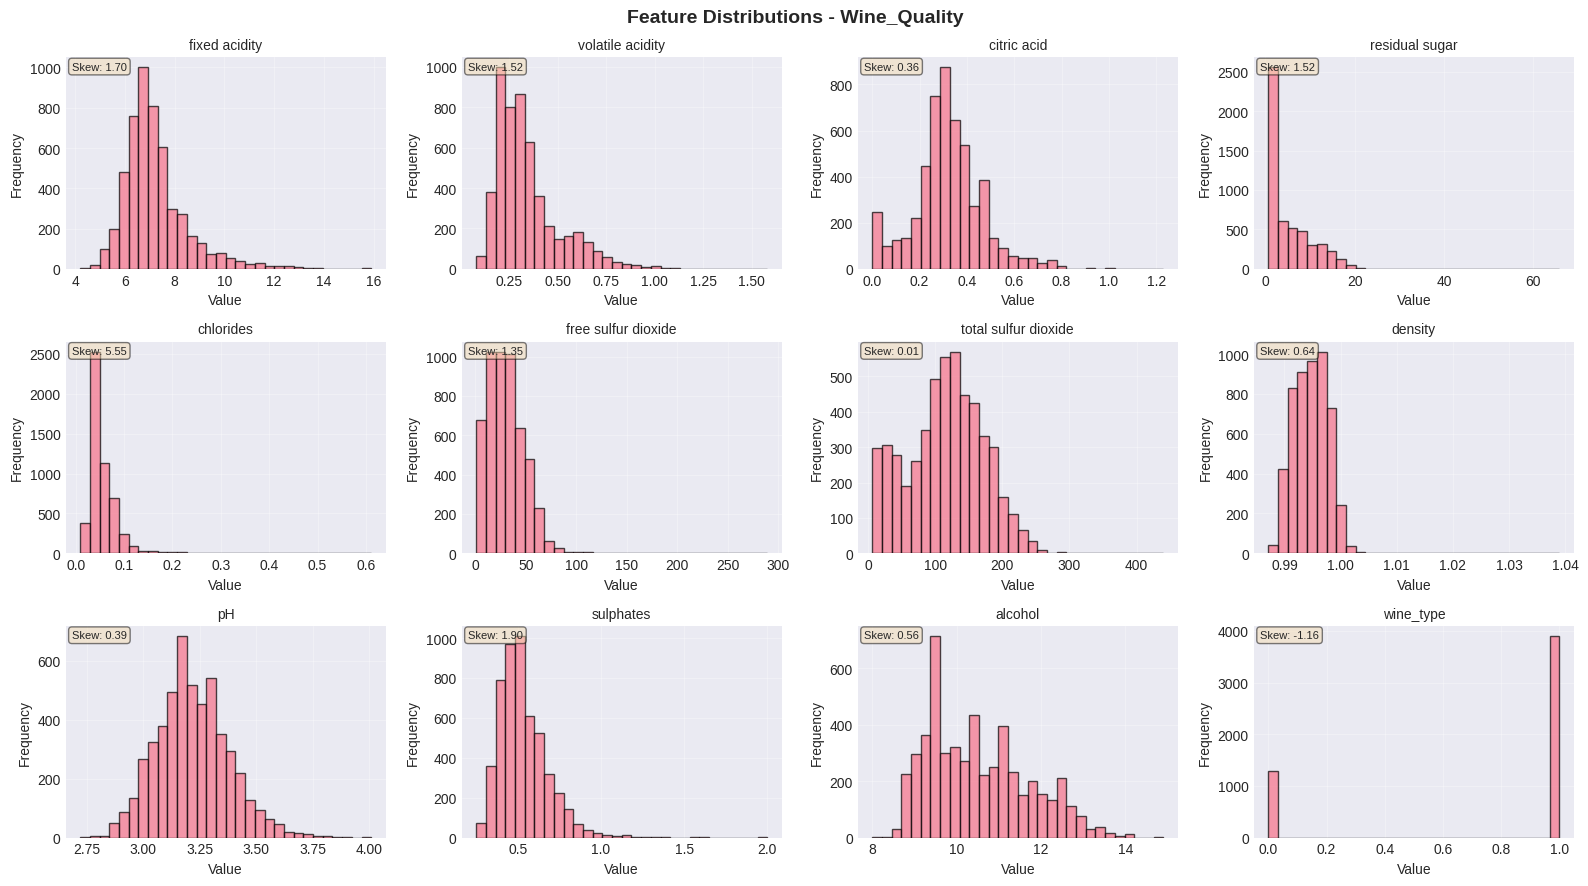

In [13]:
# Plot feature distributions
save_path = FIGURES_DIR / 'wine_quality_distributions.png'
analyzer.plot_distributions(save_path=str(save_path), max_cols=4)

Box plot saved to ../results/analysis/figures/wine_quality_boxplots.png


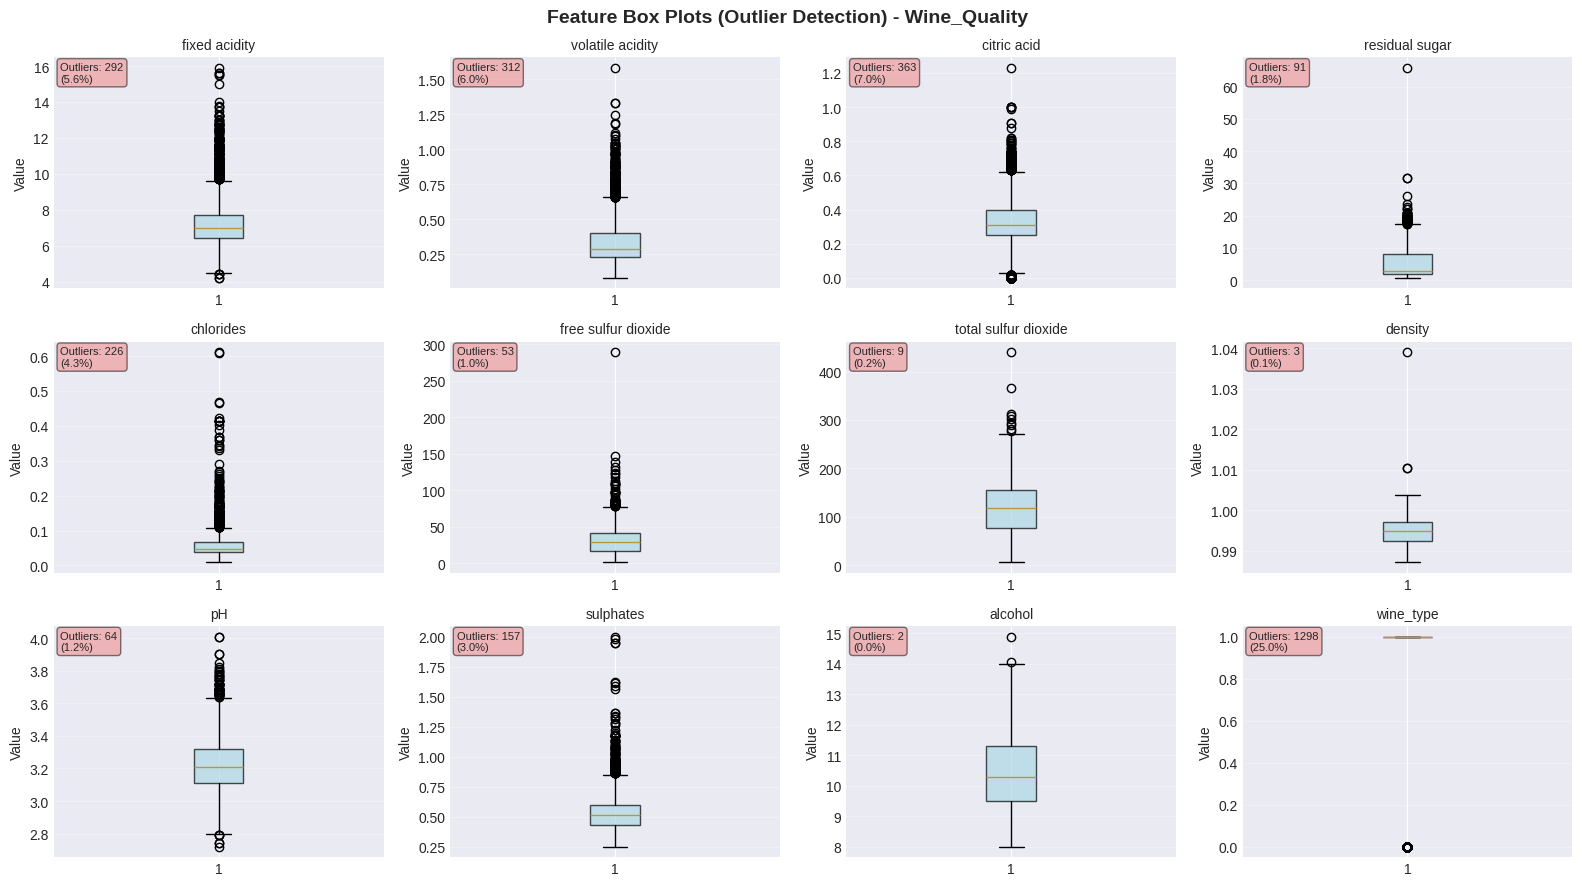

In [14]:
# Plot box plots for outlier visualization
save_path = FIGURES_DIR / 'wine_quality_boxplots.png'
analyzer.plot_boxplots(save_path=str(save_path), max_cols=4)

Correlation heatmap saved to ../results/analysis/figures/wine_quality_correlation.png


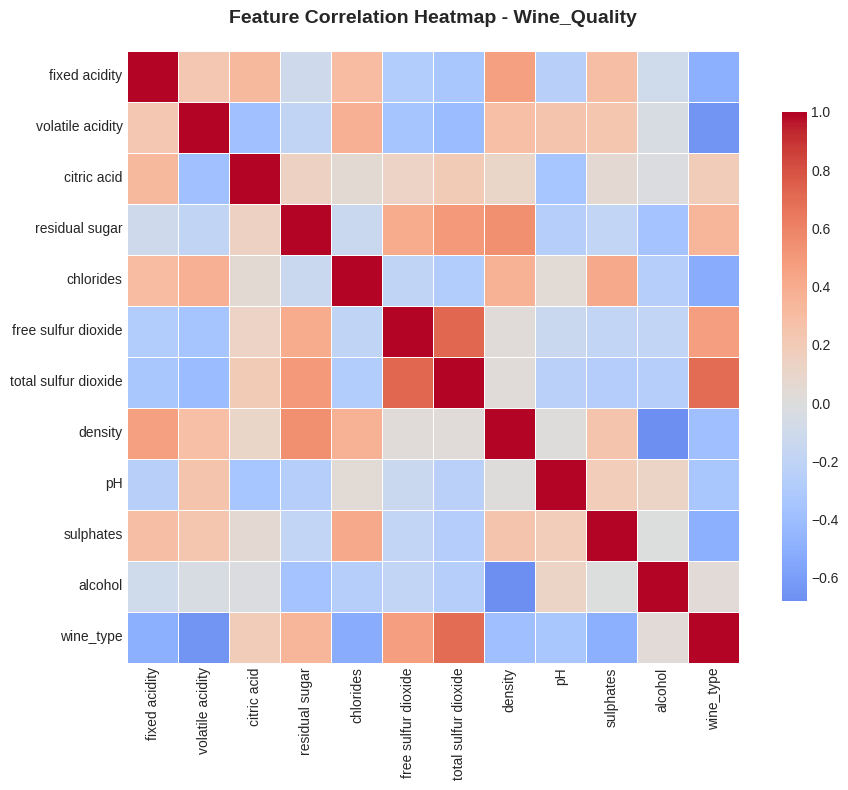

In [15]:
# Plot correlation heatmap
save_path = FIGURES_DIR / 'wine_quality_correlation.png'
analyzer.plot_correlation_heatmap(save_path=str(save_path), figsize=(10, 8), annot=False)

Scale comparison plot saved to ../results/analysis/figures/wine_quality_scale_comparison.png


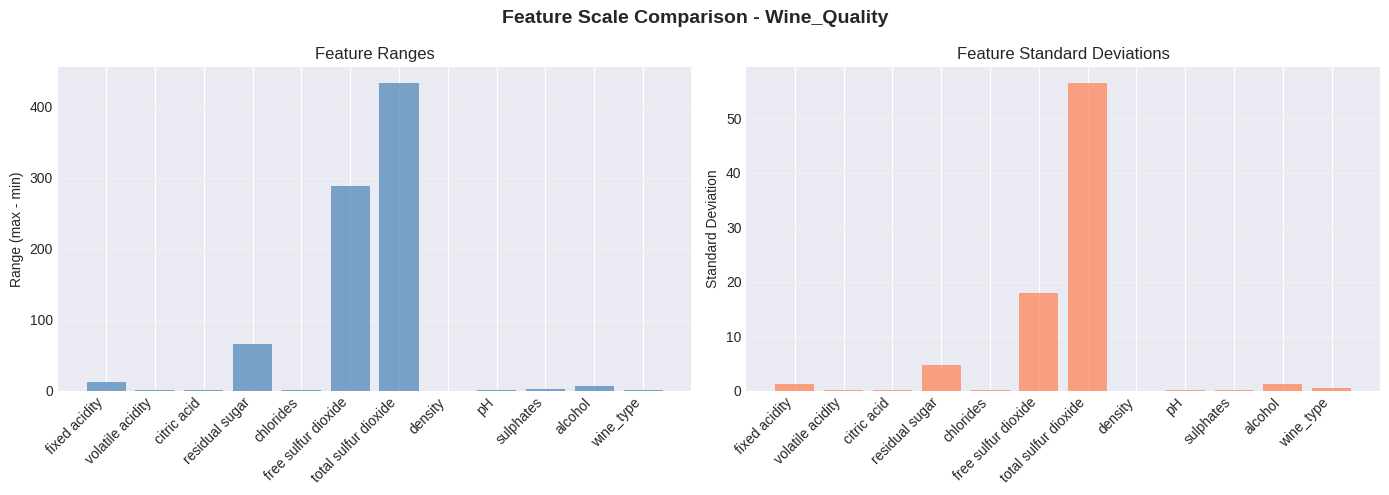

In [16]:
# Plot scale comparison
save_path = FIGURES_DIR / 'wine_quality_scale_comparison.png'
analyzer.plot_scale_comparison(save_path=str(save_path))

### 3.5 Save Feature Analysis Results

In [17]:
# Save statistics to CSV files
save_path = RESULTS_DIR / 'wine_quality'
analyzer.save_statistics(str(save_path))

print("\n✓ Feature analysis results saved!")

Distribution statistics saved to ../results/analysis/wine_quality_distribution.csv
Outlier statistics saved to ../results/analysis/wine_quality_outliers.csv
Correlation matrix saved to ../results/analysis/wine_quality_correlation.csv
Summary statistics saved to ../results/analysis/wine_quality_summary.csv

✓ Feature analysis results saved!


## 4. Baseline Models Training

Train logistic regression models with different feature scalers:
- StandardScaler
- MinMaxScaler
- RobustScaler
- MaxAbsScaler

In [18]:
# Create baseline comparison
comparison = BaselineComparison(
    scaler_names=['standard', 'minmax', 'robust', 'maxabs'],
    C_range=[0.001, 0.01, 0.1, 1, 10, 100],
    cv_folds=5,
    random_state=RANDOM_STATE,
    max_iter=1000
)

print("Baseline comparison initialized")
print(f"  Scalers: {comparison.scaler_names}")
print(f"  C range: {comparison.C_range}")
print(f"  CV folds: {comparison.cv_folds}")

Baseline comparison initialized
  Scalers: ['standard', 'minmax', 'robust', 'maxabs']
  C range: [0.001, 0.01, 0.1, 1, 10, 100]
  CV folds: 5


In [19]:
# Train all baseline models
models = comparison.fit_all(X_train, y_train, verbose=True)


TRAINING BASELINE MODELS

Training STANDARD scaler model...
  C range: [0.001, 0.01, 0.1, 1, 10, 100]
  CV folds: 5


  Training time: 1.390s
  Best C: 1.0000
  Best CV AUC: 0.8114

Training MINMAX scaler model...
  C range: [0.001, 0.01, 0.1, 1, 10, 100]
  CV folds: 5
  Training time: 0.986s
  Best C: 100.0000
  Best CV AUC: 0.8110

Training ROBUST scaler model...
  C range: [0.001, 0.01, 0.1, 1, 10, 100]
  CV folds: 5
  Training time: 0.949s
  Best C: 10.0000
  Best CV AUC: 0.8114

Training MAXABS scaler model...
  C range: [0.001, 0.01, 0.1, 1, 10, 100]
  CV folds: 5
  Training time: 0.813s
  Best C: 10.0000
  Best CV AUC: 0.8078

✓ All baseline models trained!


## 5. Evaluate Baseline Models

In [20]:
# Evaluate all models on test set
results = comparison.evaluate_all(X_test, y_test, verbose=True)


BASELINE MODEL RESULTS
  scaler  accuracy  auc_roc   pr_auc  precision   recall       f1  best_C  training_time
standard  0.823077 0.804755 0.524779   0.618182 0.265625 0.371585     1.0       1.390308
  minmax  0.823077 0.804800 0.524922   0.622642 0.257812 0.364641   100.0       0.985518
  robust  0.822308 0.804916 0.525673   0.614679 0.261719 0.367123    10.0       0.949134
  maxabs  0.825385 0.800269 0.527714   0.659341 0.234375 0.345821    10.0       0.812836

Best model by AUC-ROC:
  ROBUST: 0.8049


In [21]:
# Display detailed results
print("\n" + "="*80)
print("DETAILED BASELINE RESULTS")
print("="*80)
display(results.round(4))


DETAILED BASELINE RESULTS


,scaler,accuracy,auc_roc,pr_auc,precision,recall,f1,best_C,training_time
0,standard,0.8231,0.8048,0.5248,0.6182,0.2656,0.3716,1.0,1.3903
1,minmax,0.8231,0.8048,0.5249,0.6226,0.2578,0.3646,100.0,0.9855
2,robust,0.8223,0.8049,0.5257,0.6147,0.2617,0.3671,10.0,0.9491
3,maxabs,0.8254,0.8003,0.5277,0.6593,0.2344,0.3458,10.0,0.8128


In [22]:
# Check available columns in results
print("Available columns in results:")
print(results.columns.tolist())
print(f"\nResults shape: {results.shape}")

Available columns in results:
['scaler', 'accuracy', 'auc_roc', 'pr_auc', 'precision', 'recall', 'f1', 'best_C', 'training_time']

Results shape: (4, 9)


In [23]:
# Identify best scaler
print("\nBest Scaler by Metric:")
print("-" * 80)

# Check which metrics are available
available_metrics = []
if 'auc_roc' in results.columns:
    available_metrics.append('auc_roc')
if 'pr_auc' in results.columns:
    available_metrics.append('pr_auc')
if 'accuracy' in results.columns:
    available_metrics.append('accuracy')

for metric in available_metrics:
    best_idx = results[metric].idxmax()
    best_scaler = results.loc[best_idx, 'scaler']
    best_score = results.loc[best_idx, metric]
    metric_name = 'PR AUC' if metric == 'pr_auc' else metric.replace('_', ' ').upper()
    print(f"  {metric_name:15s}: {best_scaler:10s} ({best_score:.4f})")


Best Scaler by Metric:
--------------------------------------------------------------------------------
  AUC ROC        : robust     (0.8049)
  PR AUC         : maxabs     (0.5277)
  ACCURACY       : maxabs     (0.8254)


## 6. Visualize Results

Performance comparison saved to ../results/analysis/figures/baseline_performance_comparison.png


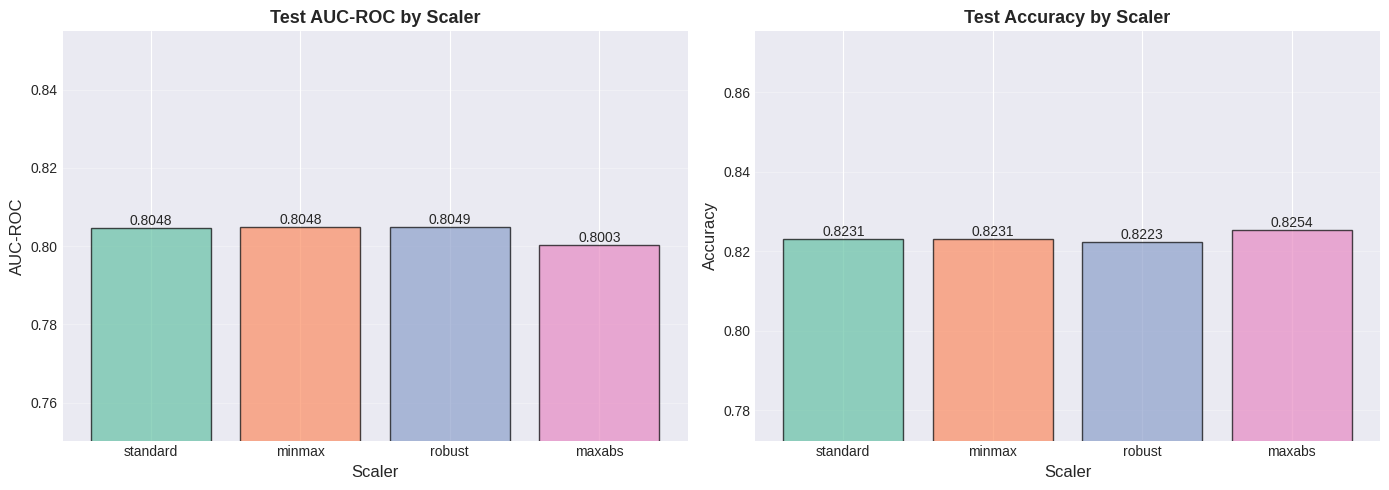

In [24]:
# Plot performance comparison
save_path = FIGURES_DIR / 'baseline_performance_comparison.png'
comparison.plot_performance_comparison(save_path=str(save_path))

Training time comparison saved to ../results/analysis/figures/baseline_training_time.png


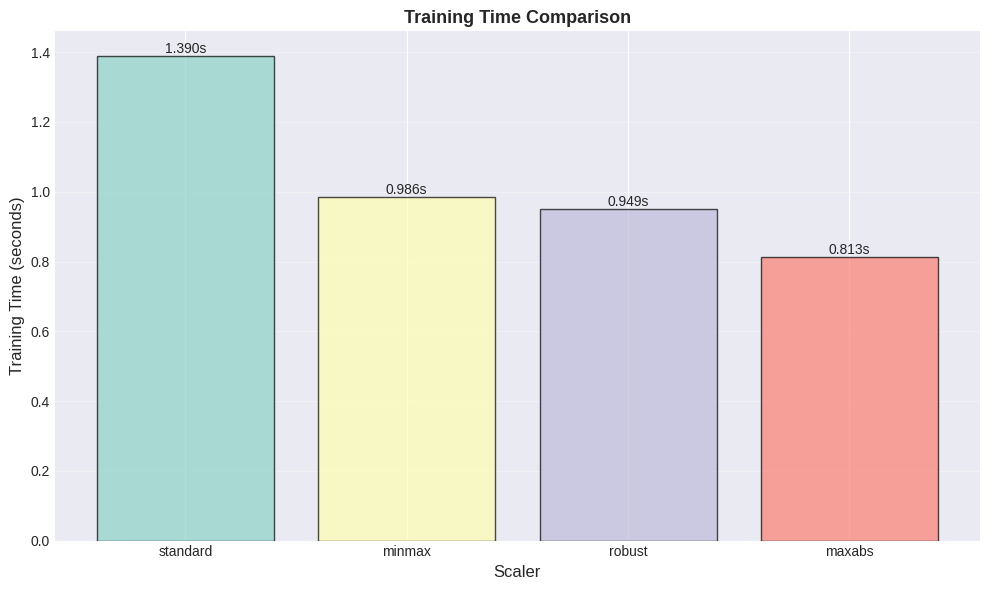

In [25]:
# Plot training time comparison
save_path = FIGURES_DIR / 'baseline_training_time.png'
comparison.plot_training_time_comparison(save_path=str(save_path))

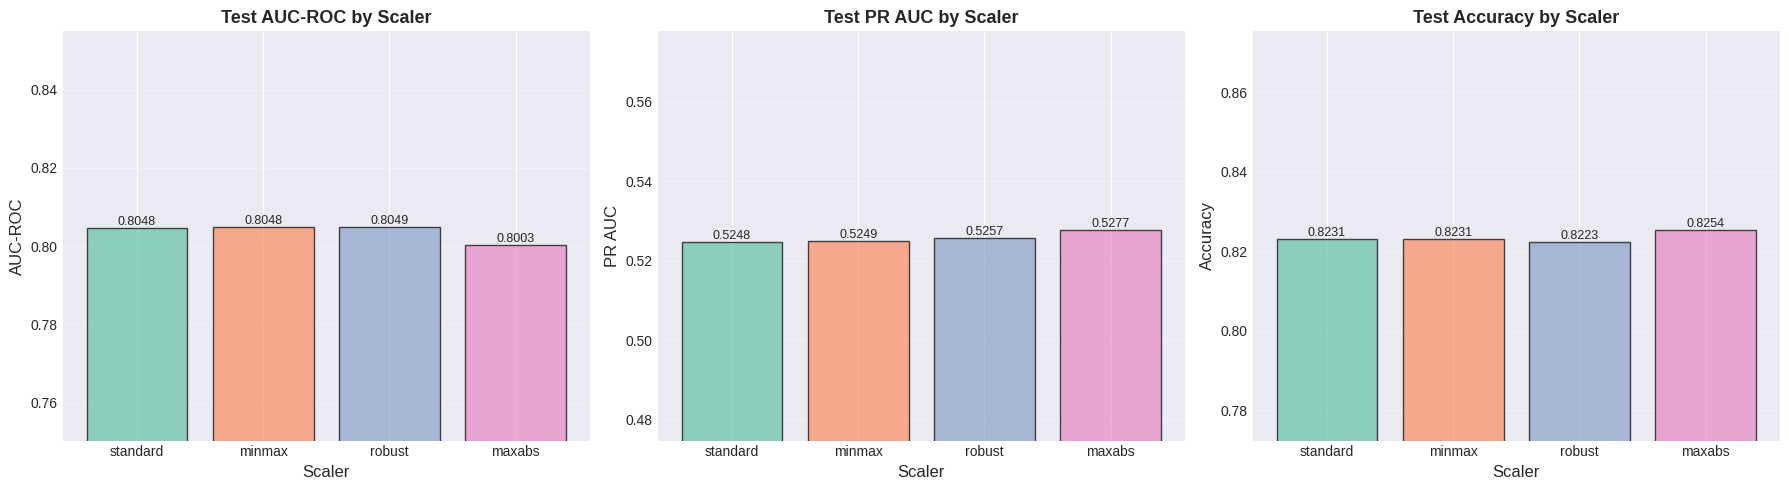

✓ Saved to ../results/analysis/figures/baseline_all_metrics.png


In [26]:
# Create custom comparison plot
# Determine which metrics to plot
plot_metrics = []
plot_titles = []

if 'auc_roc' in results.columns:
    plot_metrics.append('auc_roc')
    plot_titles.append('AUC-ROC')
if 'pr_auc' in results.columns:
    plot_metrics.append('pr_auc')
    plot_titles.append('PR AUC')
if 'accuracy' in results.columns:
    plot_metrics.append('accuracy')
    plot_titles.append('Accuracy')

n_metrics = len(plot_metrics)
if n_metrics > 0:
    fig, axes = plt.subplots(1, n_metrics, figsize=(6*n_metrics, 5))
    if n_metrics == 1:
        axes = [axes]
    
    colors = plt.cm.Set2(range(len(results)))
    
    for ax, metric, title in zip(axes, plot_metrics, plot_titles):
        bars = ax.bar(results['scaler'], results[metric], color=colors, alpha=0.7, edgecolor='black')
        ax.set_ylabel(title, fontsize=12)
        ax.set_xlabel('Scaler', fontsize=12)
        ax.set_title(f'Test {title} by Scaler', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim([results[metric].min() - 0.05, min(1, results[metric].max() + 0.05)])
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}',
                    ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    save_path = FIGURES_DIR / 'baseline_all_metrics.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved to {save_path}")
else:
    print("No metrics available to plot")

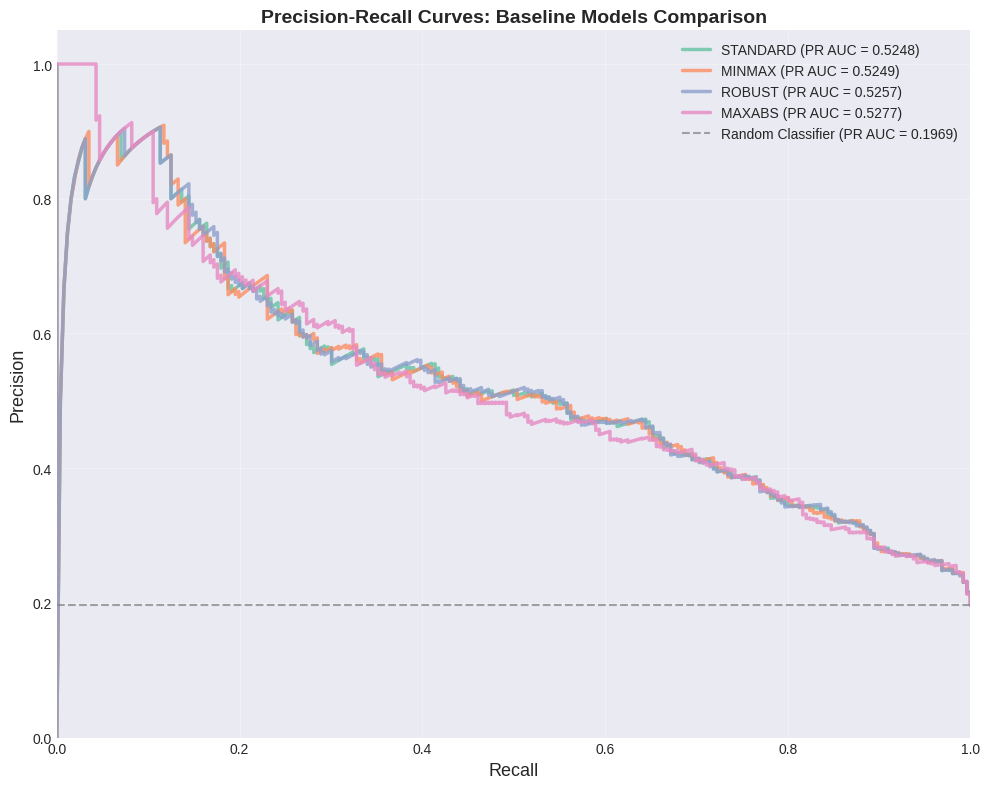

✓ Precision-Recall curves saved to ../results/analysis/figures/baseline_precision_recall_curves.png


In [27]:
# Plot Precision-Recall curves for all scalers
from sklearn.metrics import precision_recall_curve

fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.Set2(range(len(results)))
scaler_names = results['scaler'].values

for idx, scaler_name in enumerate(scaler_names):
    # Get the model
    model = comparison.models[scaler_name]
    
    # Get predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    
    # Get PR AUC score
    pr_auc = results.loc[results['scaler'] == scaler_name, 'pr_auc'].values[0]
    
    # Plot
    ax.plot(recall, precision, color=colors[idx], linewidth=2.5, 
            label=f'{scaler_name.upper()} (PR AUC = {pr_auc:.4f})', alpha=0.8)

# Add baseline (random classifier)
baseline_precision = y_test.sum() / len(y_test)
ax.axhline(y=baseline_precision, color='gray', linestyle='--', linewidth=1.5, 
           label=f'Random Classifier (PR AUC = {baseline_precision:.4f})', alpha=0.7)

ax.set_xlabel('Recall', fontsize=13)
ax.set_ylabel('Precision', fontsize=13)
ax.set_title('Precision-Recall Curves: Baseline Models Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
save_path = FIGURES_DIR / 'baseline_precision_recall_curves.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Precision-Recall curves saved to {save_path}")

## 7. Statistical Comparison (Optional)

In [28]:
# Perform statistical comparison using repeated cross-validation
# This takes a bit longer but provides statistical significance tests

RUN_STATISTICAL_TESTS = True  # Set to False to skip

if RUN_STATISTICAL_TESTS:
    # Combine train and test for CV
    X_full = np.vstack([X_train, X_test])
    y_full = np.hstack([y_train, y_test])
    
    stats_df = comparison.statistical_comparison(X_full, y_full, n_iterations=10)
    
    # Save statistical results
    save_path = RESULTS_DIR / 'wine_quality_statistical_comparison.csv'
    stats_df.to_csv(save_path, index=False)
    print(f"\n✓ Statistical comparison saved to {save_path}")
else:
    print("Statistical tests skipped (set RUN_STATISTICAL_TESTS=True to enable)")


STATISTICAL COMPARISON (Repeated Cross-Validation)
Running 10 iterations of 5-fold CV...

Cross-Validation Statistics:
  scaler  mean_auc  std_auc  min_auc  max_auc  median_auc
standard  0.809912 0.006931 0.805897 0.823740    0.806446
  minmax  0.809634 0.006889 0.805507 0.823368    0.806386
  robust  0.809963 0.006876 0.805882 0.823676    0.806405
  maxabs  0.806091 0.007683 0.800314 0.821170    0.802926

Pairwise T-Tests (p-values):
------------------------------------------------------------
  standard vs minmax  : p=0.0123 *
  standard vs robust  : p=0.0036 **
  standard vs maxabs  : p=0.0000 ***
  minmax   vs robust  : p=0.0048 **
  minmax   vs maxabs  : p=0.0000 ***
  robust   vs maxabs  : p=0.0000 ***

  * p < 0.05, ** p < 0.01, *** p < 0.001

✓ Statistical comparison saved to ../results/analysis/wine_quality_statistical_comparison.csv


## 8. Save Results

In [29]:
# Save baseline results
results_path = RESULTS_DIR / 'wine_quality_baseline_results.csv'
results.to_csv(results_path, index=False)
print(f"✓ Baseline results saved to {results_path}")

# Also save with 'all' prefix for compatibility
all_results_path = RESULTS_DIR / 'all_baseline_results.csv'
results['dataset'] = 'Wine Quality'
results.to_csv(all_results_path, index=False)
print(f"✓ Combined results saved to {all_results_path}")

✓ Baseline results saved to ../results/analysis/wine_quality_baseline_results.csv
✓ Combined results saved to ../results/analysis/all_baseline_results.csv
